# Instruções para reproduzir os resultados do modelo final

In [ ]:
# instalar todas as bibliotecas utilizadas
!pip install -r requirements.txt

## 1. Pré-processar o conjunto de dados

Execute as celulas abaixo para realizar o pré-processar os dados presentes no arquivo 'ep2-pln-train.xlsx' dentro da pasta 'data'. Você deve obter como resultado o arquivo 'enc_tok_nopunct_lemm.csv' que está armazenado em 'data'

In [32]:
from preprocess import preprocess
import pandas as pd
import numpy as np
from scipy.sparse import save_npz, load_npz

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer

import pickle

import shap

import warnings

warnings.filterwarnings("ignore")

seed = np.random.seed(777)

In [4]:
df = pd.read_excel('data/ep2-pln-train.xlsx')

preprocess.encode_class(df, 'age')

preprocess.tokenize(df, 'req_text', True, True)

preprocess.lemmatize(df, 'word_tokens', True)

df.to_csv('data/enc_tok_nopunct_lemm.csv', index=False)

## 2. Vetorizar conjunto de dados limpo

Execute o notebook jupyter 'vectorizer.ipynb' que está no diretório 'processing'. Você deve obter como resultado os arquivos {'X_train_Tfidf.npz', 'X_test_Tfidf.npz', 'y_train.npy', 'y_test.npy'} armazenado em 'vects'

In [5]:
df = pd.read_csv('data/enc_tok_nopunct_lemm.csv')

X_labels = [i for i in df.columns if (i != 'age' and i != 'age_encoded')]
X = df['lemma']
y = df['age_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, stratify=df['age_encoded'], random_state=seed)

tfidf_vect = TfidfVectorizer(max_features=5000)
tfidf_vect.fit(X)

X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

save_npz('vectors/tfidf_lemma/X_train_tfidf.npz', X_train_tfidf)
save_npz('vectors/tfidf_lemma/X_test_tfidf.npz', X_test_tfidf)

np.save('vectors/tfidf_lemma/y_train.npy', y_train)
np.save('vectors/tfidf_lemma/y_test.npy', y_test)

## 3. Escolha doshiperparâmetros dos modelos selecionados

### 3.0 Carregar vetores de treino e teste

In [79]:
X_train = load_npz('vectors/tfidf_lemma/X_train_tfidf.npz')
X_test = load_npz('vectors/tfidf_lemma/X_test_tfidf.npz')

y_train = np.load('vectors/tfidf_lemma/y_train.npy', allow_pickle=True)
y_test = np.load('vectors/tfidf_lemma/y_test.npy', allow_pickle=True)

### 3.1 Melhores hiperparâmetros

Para encontrar os melhores hiperparâmetros utilizamos a biblioteca 'optuna', mais detatlhes de como essa busca foi feita estão no arquivo 'NB_SVM_RF_tfidf.ipynb' dentro do diretório 'classic_models'. Aqui apenas treinaremos os modelos usando os hiperparâmetros encontrados.

In [7]:
class_weights = dict(zip(range(len(np.unique(y_train))), 1 / np.bincount(y_train)))
labels = ['0','1','2','3']

SVM_params = {
    'class_weight': 'balanced', 
    'probability': True,
}

RF_params = {
    'n_estimators': 167,
    'max_depth': 176,
    'class_weight': class_weights,
}

In [8]:
SVM = SVC(**SVM_params)
RF = RandomForestClassifier(**RF_params)

In [9]:
SVM.fit(X_train, y_train)
RF.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.0010416666666666667, 1: 0.000625,
                                     2: 0.0004166666666666667, 3: 0.000625},
                       max_depth=176, n_estimators=167)

In [10]:
SVM_y_pred = SVM.predict(X_test)
RF_y_pred = RF.predict(X_test)

In [11]:
cm_SVM = confusion_matrix(y_test, SVM_y_pred)
cm_SVM = cm_SVM.astype('float') / cm_SVM.sum(axis=1)[:, np.newaxis]

cm_RF = confusion_matrix(y_test, RF_y_pred)
cm_RF = cm_RF.astype('float') / cm_RF.sum(axis=1)[:, np.newaxis]

### 3.2 visualização dos resultados em cada classe
optamos por gerar matrizes de confusão para verificar como os modelos estavam obtendo a sua acurácia média, dado que o conujunto de dados era desbalanceado.

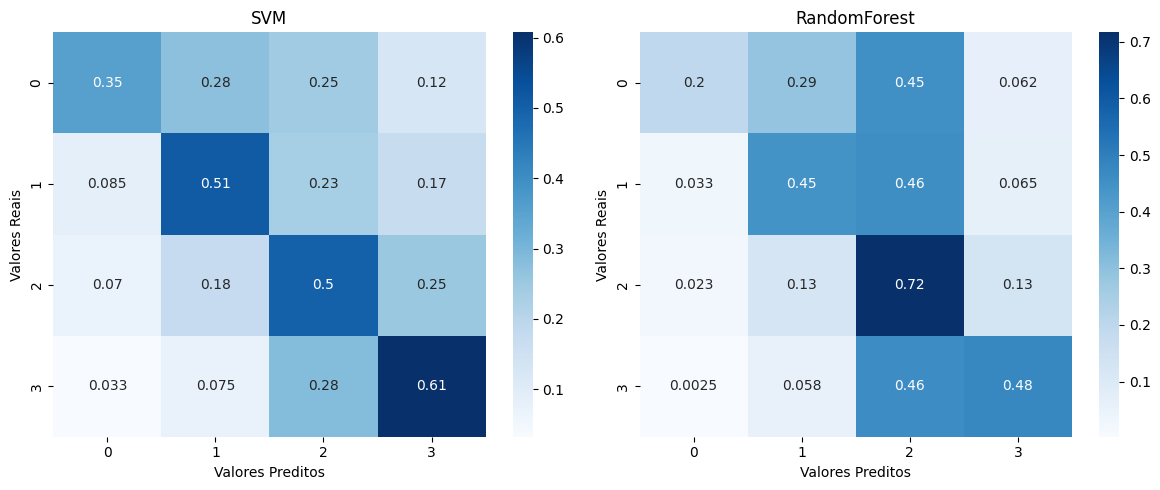

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for i, (cm, model_name) in enumerate(zip([cm_SVM, cm_RF], ['SVM', 'RandomForest'])):
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, ax=axes[i])
    axes[i].set_title(f'{model_name}')
    axes[i].set_xlabel('Valores Preditos')
    axes[i].set_ylabel('Valores Reais')

plt.tight_layout()
plt.show()

In [13]:
with open('models_dump/SVM_CV50_T50.pkl', 'wb') as file:
    pickle.dump(SVM, file)

with open('models_dump/RF_CV51_T51.pkl', 'wb') as file:
    pickle.dump(RF, file)

## 4. Gerando ensemble dos modelos selecionados

In [14]:
weights = {'RF': [1,1,1,3], 'SVM': [3,2,2,1]}

In [15]:
def get_weighted_probabilities(models, X, weights):
    probabilities = [model.predict_proba(X) * weight for (model, weight) in zip(models, weights.values())]
    return np.sum(probabilities, axis=0)

In [16]:
ensemble_proba = get_weighted_probabilities([SVM, RF], X_test, weights)

ensemble_model = VotingClassifier(estimators=[
    ('RF', RF),
    ('SVM', SVM)
], voting='soft', weights=weights)

In [17]:
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(class_weight={0: 0.0010416666666666667,
                                                                   1: 0.000625,
                                                                   2: 0.0004166666666666667,
                                                                   3: 0.000625},
                                                     max_depth=176,
                                                     n_estimators=167)),
                             ('SVM',
                              SVC(class_weight='balanced', probability=True))],
                 voting='soft',
                 weights={'RF': [1, 1, 1, 3], 'SVM': [3, 2, 2, 1]})

### 4.1 Acurácia do ensemble no conjunto de teste

In [18]:
ensemble_predictions = np.argmax(ensemble_proba, axis=1)
print(f'Acurácia do Ensemble: {accuracy_score(y_test, ensemble_predictions)}')

Acurácia do Ensemble: 0.5158536585365854


### 4.2 Acurácia média do ensemble em um cross validation com 10 folds
Obs.: Criamos uma função para esse ensemble, pois a função 'cross_validation_score' do sklearn não suporta os modelos que usamos. Entretanto, vale ressaltar que utilizamos a função 'Kfold' do 'sklearn' para manter a consistência.

In [19]:
def cv_scores(X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Inicializando listas para armazenar pontuações
    cross_val_scores = []

    # Realizando a validação cruzada manualmente
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Treinando os modelos com pesos
        SVM.fit(X_train, y_train)
        RF.fit(X_train, y_train)

        # Calculando probabilidades ponderadas usando a função personalizada
        weighted_probabilities = get_weighted_probabilities([SVM, RF], X_test, weights)

        # Convertendo probabilidades para previsões
        ensemble_predictions = np.argmax(weighted_probabilities, axis=1)

        # Calculando a acurácia e armazenando
        accuracy = np.sum(ensemble_predictions == y_test) / len(y_test)
        cross_val_scores.append(accuracy)
    return cross_val_scores

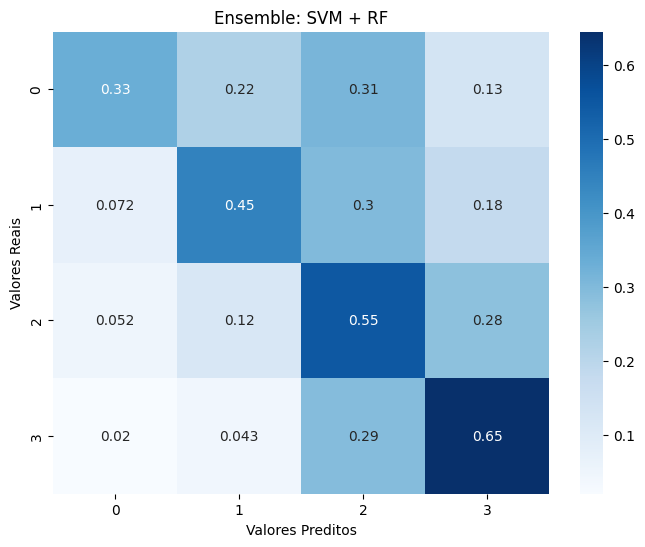

In [222]:
cm = confusion_matrix(y_test, ensemble_predictions)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Ensemble: SVM + RF')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

In [21]:
cross_val_scores = cv_scores(X_train, y_train)

# Exibindo as pontuações para cada fold
print("Pontuações da validação cruzada:", cross_val_scores)

# Exibindo a média das pontuações
print("Média das pontuações da validação cruzada:", np.mean(cross_val_scores))

Pontuações da validação cruzada: [0.5213414634146342, 0.5015243902439024, 0.5320121951219512, 0.5228658536585366, 0.5213414634146342, 0.5060975609756098, 0.48628048780487804, 0.5228658536585366, 0.4817073170731707, 0.5320121951219512]
Média das pontuações da validação cruzada: 0.5128048780487804


In [22]:
with open('models_dump/SVM+RF_CV52_T50.pkl', 'wb') as file:
    pickle.dump(ensemble_model, file)

## 5. Explicabilidade dos modelos

In [199]:
X_train = load_npz('vectors/tfidf_lemma/X_train_tfidf.npz')
X_test = load_npz('vectors/tfidf_lemma/X_test_tfidf.npz')

y_train = np.load('vectors/tfidf_lemma/y_train.npy', allow_pickle=True)
y_test = np.load('vectors/tfidf_lemma/y_test.npy', allow_pickle=True)

In [201]:
X_train = pd.DataFrame(X_train.todense(), columns=range(X_train.shape[1]))
X_test = pd.DataFrame(X_test.todense(), columns=range(X_test.shape[1]))

In [202]:
X_train[1:3]

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.124663,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [216]:
def make_predictions(X_batch_text):
    
    ensemble_proba = get_weighted_probabilities([SVM, RF], X_batch_text, weights)
    preds = np.argmax(ensemble_proba, axis=1)
    #preds = [str(v) for v in preds]
    return preds

In [207]:
input_df = pd.read_csv('data/enc_tok_nopunct_lemm.csv')

In [210]:
input_df['lemma'][1:2].values[0]

'solicito cópia de o ata de o conselho de administração de o bnde que ter ocorrer entre jan17 e 25042018 em o íntegra parecer de o auditoria interno de o bnde quanto o revisão de o cálculo de o índice corporativo para fim de apuração de o valor de o plr o'

In [219]:
input = tfidf_vect.transform(input_df['lemma'][1:2])
input

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [221]:
input_df = pd.read_csv('data/enc_tok_nopunct_lemm.csv')

masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(make_predictions, masker=masker, output_names=['0','1','2','3'])
input = tfidf_vect.transform(input_df['lemma'][1:2])
shap_values = explainer(input)


TypeError: expected string or bytes-like object, got 'csr_matrix'